# Planning Stage - Christin Wang #

In [2]:
library(MASS)
library(tidyverse)
library(repr)
library(infer)
library(cowplot)
library(broom)
library(GGally)
library(AER)
library(broom)
library(modelr)

Warning message:
"程辑包'tidyverse'是用R版本4.3.3 来建造的"
Warning message:
"程辑包'forcats'是用R版本4.3.3 来建造的"
Warning message:
"程辑包'lubridate'是用R版本4.3.3 来建造的"
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
✖ dplyr::select() masks MASS::select()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Warning message:
"程辑包'infer'是用R版本4.3.3 来建造的"
Warning message:
"程辑包'cowplot'是用R版本4.3.3 来建造的"

载入程辑包：'cowplot'


The following object is masked from 'package:lubridate':

    stamp


Warning message:
"程辑包'broom'是用R版本4.3.3 来建造的"
Warning message:
"程辑包'GGally'是用R版本4.3.3 来建造的"
Registered S3 method

## I. Data Description ##

The Cleveland heart disease dataset, sourced from the UCI repository, was originally donated on 6/30/1988, contributed by A. Janosi, W. Steinbrunn, M. Pfisterer, R. Detrano, etc. It was collected from medical records for heart disease research. The primary use of this dataset is to distinguish between the presence (values 1, 2, 3, 4) and absence (value 0) of heart disease. For this project, we are going to use the Processed Cleveland data, containing 303 rows and 14 columns (extracted from a larger set of 76).


The dataset contains 13 attributes and a target variable, with 8 categorical variables and 5 numerical variables. The detailed description are as follows:
1. age: age in years
2. sex: sex (1 = male; 0 = female)
3. cp: chest pain type
    - Value 1: typical angina
    - Value 2: atypical angina
    - Value 3: non-anginal pain
    - Value 4: asymptomatic
4. trestbps: resting blood pressure (in mm Hg on admission to the hospital)
5. chol: serum cholestoral in mg/dl
6. fbs: (fasting blood sugar > 120 mg/dl)  (1 = true; 0 = false)
7. restecg: resting electrocardiographic results
    - Value 0: normal
    - Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    - Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria
8. thalach: maximum heart rate achieved
9. exang: exercise induced angina (1 = yes; 0 = no)
10. oldpeak: ST depression induced by exercise relative to rest
11. slope: the slope of the peak exercise ST segment
    - Value 1: upsloping
    - Value 2: flat
    - Value 3: downsloping
12. ca: number of major vessels (0-3) colored by fluoroscopy
13. thal: 3 = normal; 6 = fixed defect; 7 = reversible defect
14. num: diagnosis of heart disease
    - Value 0: absence
    - Value 1,2,3,4: presence


## II. Question ##

- Can we predict the probability of the presence of heart disease in a patient by using clinical variables?

- The dataset contains 13 variables that are potential predictors of heart disease. By splitting the data into train & test, picking the input variables that provide the best goodness of fit, we can build a logistic regression model to predict the probability of a patient having heart disease.


## III. Exploratory Data Analysis and Visualization ##

1. Data preperation

- Read the csv file of `processed.cleveland.data`.
- Rename the column names of the dataset.
- Change the diagnosis presence values 1,2,3,4 all into 1.

In [3]:
heart_data <- read_csv("https://raw.githubusercontent.com/Speculatorrr/STAT301/main/processed.cleveland.data?token=GHSAT0AAAAAACVKAVDCISXAPJBRTBVAWBUQZVEDPNQ", 
                        col_names = FALSE)
colnames(heart_data) <- c("age", "sex", "cp", "trestbps", "chol",
                            "fbs", "restecg", "thalach", "exang", "oldpeak",
                            "slope", "ca", "thal", "num")

heart_data <- mutate(heart_data, num = if_else(num > 0, 1, 0))

head(heart_data)

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,1
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0
56,1,2,120,236,0,0,178,0,0.8,1,0.0,3.0,0


2. Visualization

- Draw the binary results of the Heart Disease Diagnosis `num` into a histograph.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


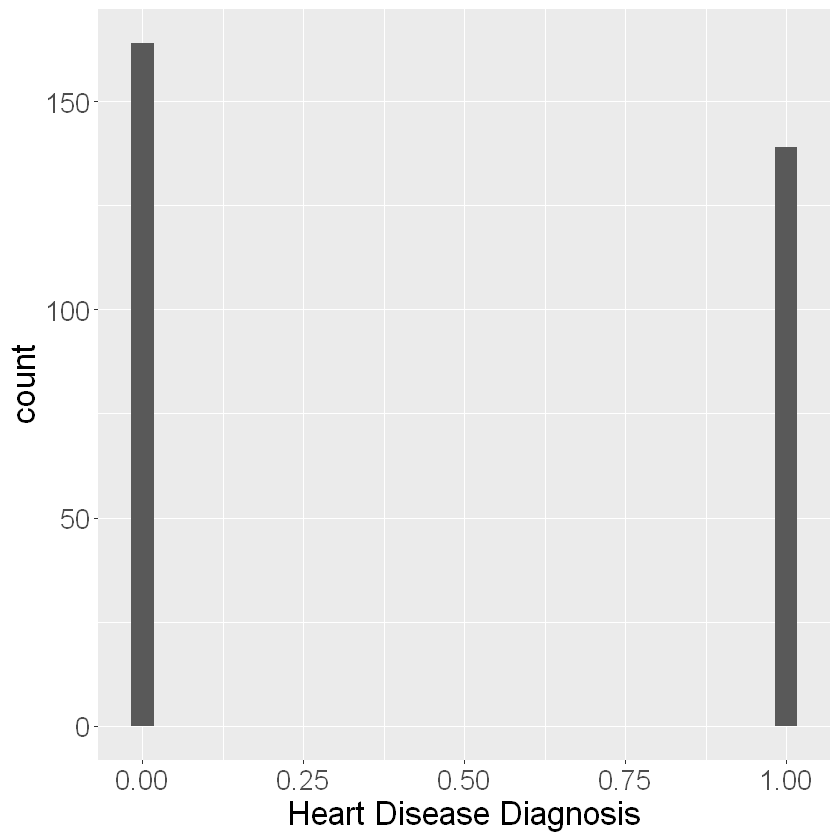

In [4]:
heart_goal_hist <- 
    heart_data %>%
    ggplot() +
    geom_histogram( aes (x=num)) +
    xlab("Heart Disease Diagnosis") +
    theme(text = element_text(size = 20))

heart_goal_hist

- Visualize the relationship between the variables in the data by `ggpair`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwid

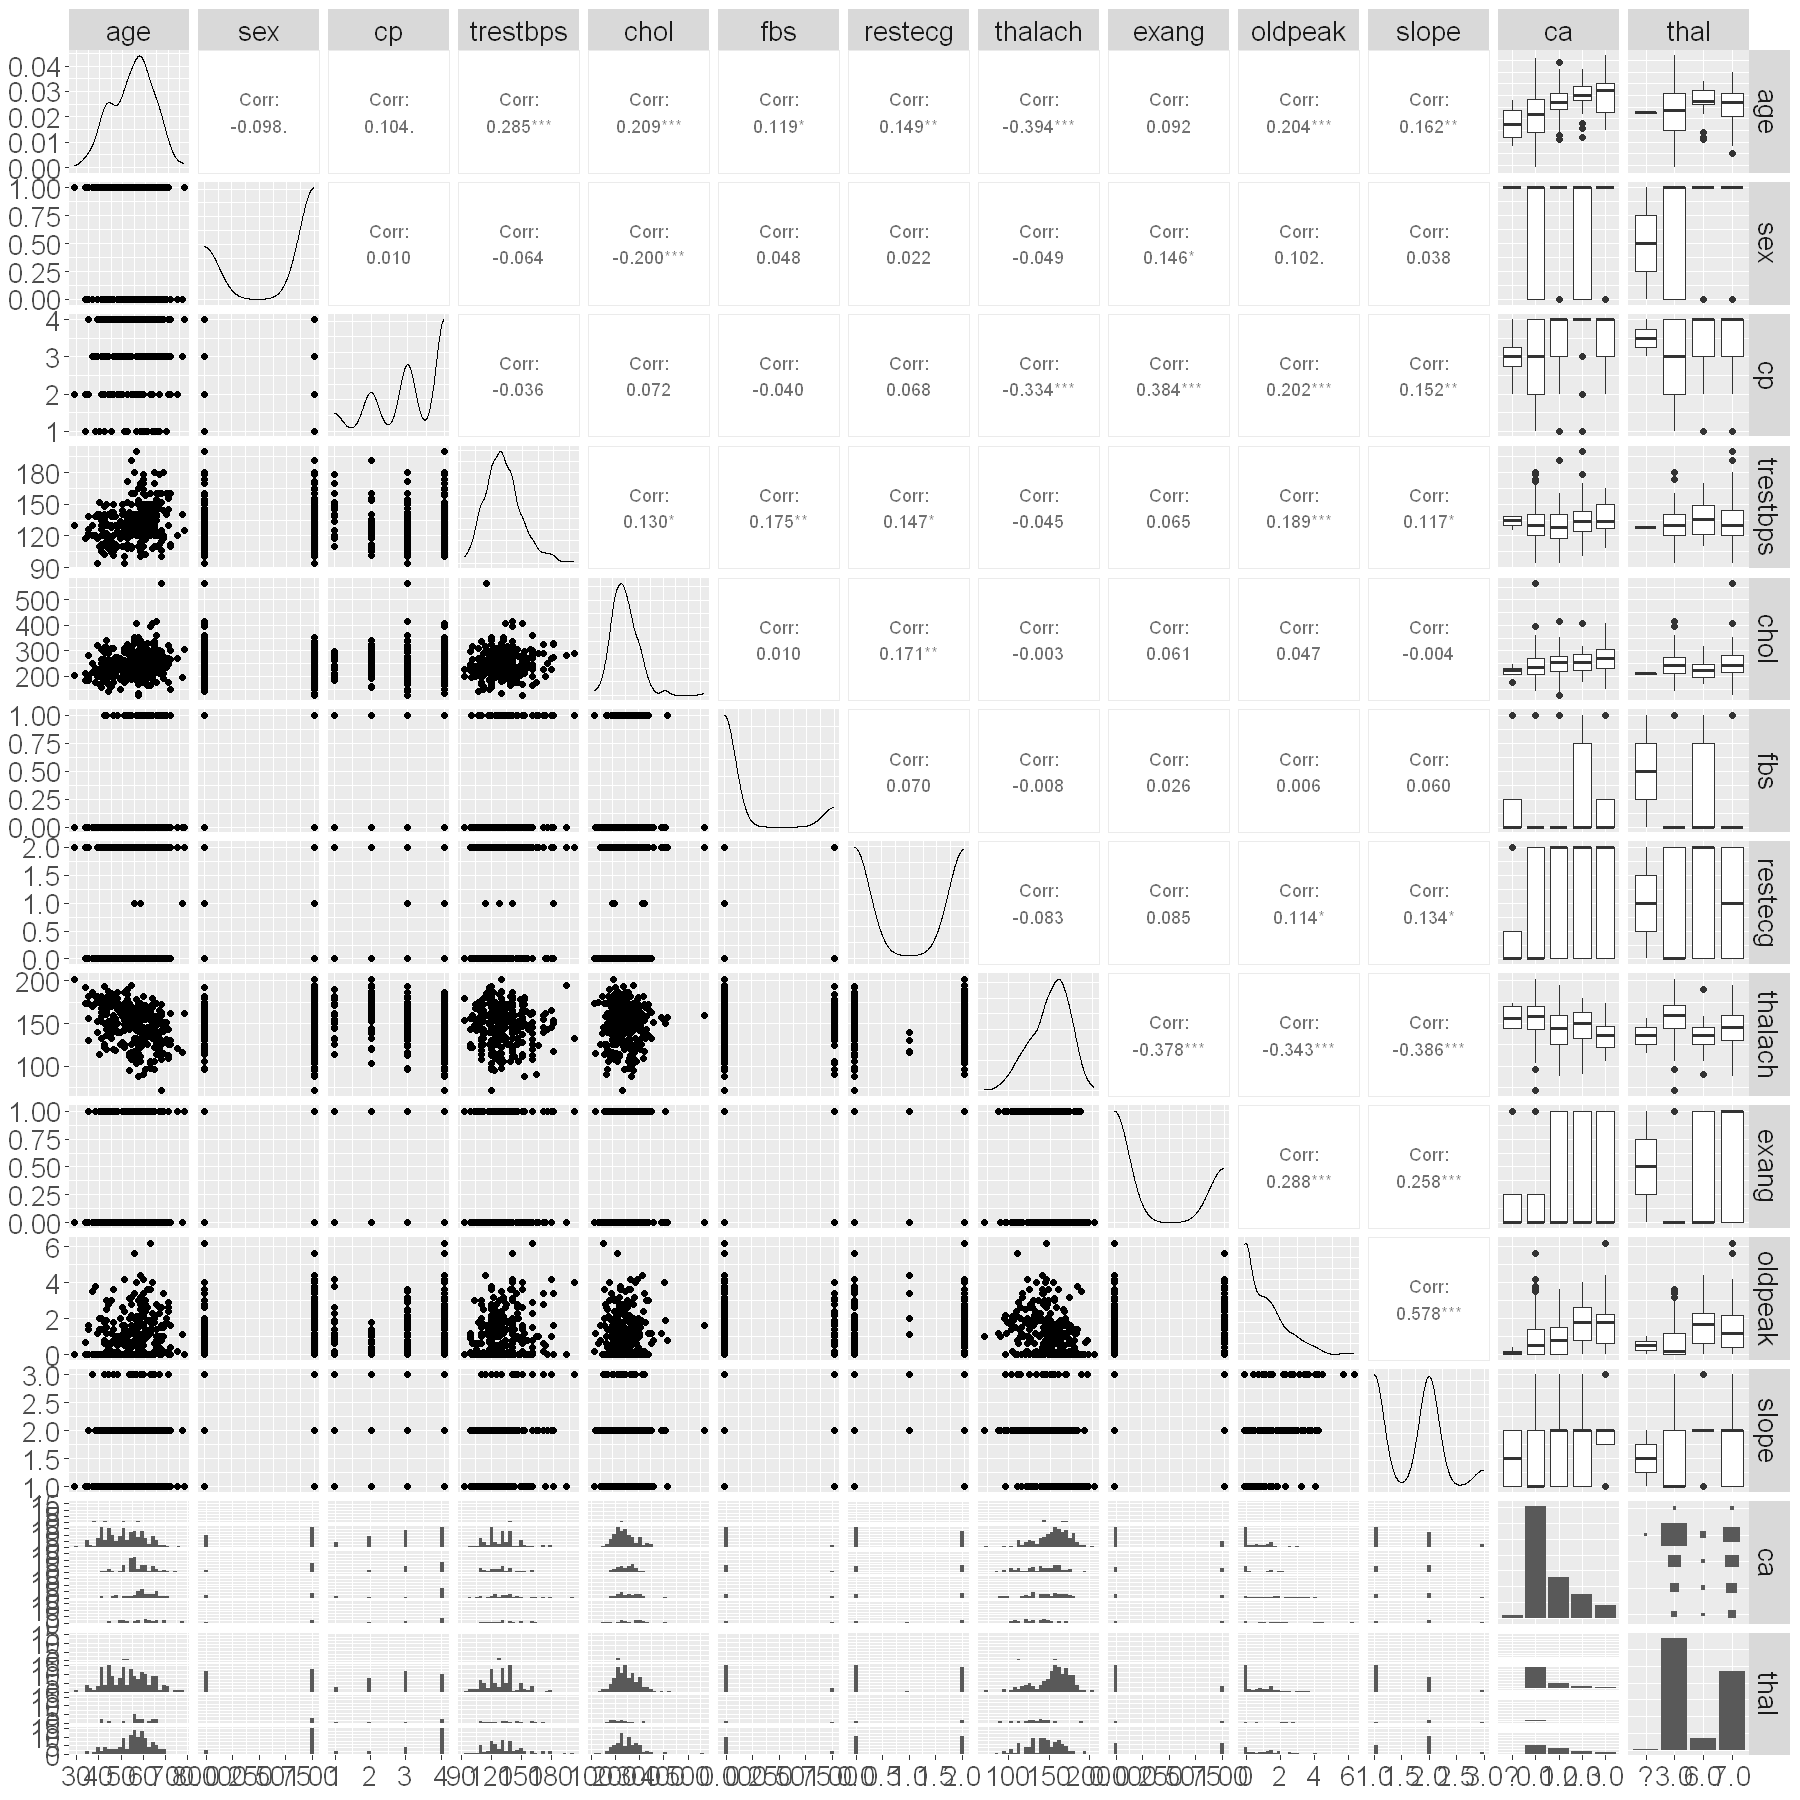

In [8]:
options(repr.plot.width = 15, repr.plot.height = 15) 

heart_pair <- 
    heart_data %>%
    select(-num) %>%
    ggpairs(progress = FALSE) +
    theme(text = element_text(size = 20))

heart_pair

## IV. Methods and Plan ##